In [72]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn.functional as Fchat
import random
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [ ]:
def get_cifar100_loaders(batch_size=500):
	transform = transforms.Compose([
		transforms.RandomCrop(32, padding=4),
		transforms.RandomHorizontalFlip(),
		transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
		transforms.ToTensor(),
		transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
	])
	
	trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
	testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
	

	# Trim dataset to make it divisible by 5
	# Define split sizes (cumulative percentages: 20%, 40%, 60%, 80%, 100%)
	total_size = len(trainset)
	split_sizes = [int(total_size * p) for p in [0.2, 0.4, 0.6, 0.8, 1.0]]

	# Ensure the sum does not exceed dataset size (due to rounding)
	split_sizes[-1] = total_size  # Ensure last split gets exactly the full dataset

	# Perform the splits
	sub_datasets = [random_split(trainset, [s, total_size - s])[0] for s in split_sizes]
	sub_dataloaders = [DataLoader(subset, batch_size=batch_size, shuffle=True) for subset in sub_datasets]

	testloader = DataLoader(testset, batch_size=500, shuffle=True, num_workers=1) #testloader always has size 500
	
	return sub_dataloaders, testloader

In [74]:
class ResidualBlock(nn.Module):
	def __init__(self, inchannel, outchannel, stride=1):
		super(ResidualBlock, self).__init__()

		self.pre_activations1 = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
			nn.BatchNorm2d(outchannel))
		
		self.pre_activations2 = nn.Sequential(
			nn.ReLU(),
			nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(outchannel)
		)

		self.shortcut = nn.Sequential()
		if stride != 1 or inchannel != outchannel:
			self.shortcut = nn.Sequential(
				nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
				nn.BatchNorm2d(outchannel)
			)
			
	def forward(self, x):
		pre_activations = self.pre_activations1(x)
		pre_activations2 = self.pre_activations2(pre_activations)
		out = pre_activations2 + self.shortcut(x)
		out = F.relu(out)
		return out, pre_activations, pre_activations2

class ResNet(nn.Module):
	def __init__(self, ResidualBlock, num_classes=100):
		super(ResNet, self).__init__()
		self.inchannel = 64
		self.conv1 = nn.Sequential(
			nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
			nn.BatchNorm2d(64),
			nn.ReLU()
		)
		self.layer1 = self.make_layer(ResidualBlock, 64, 2, stride=1)
		self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
		self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)        
		self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
		self.fc = nn.Linear(512, num_classes)
		
	def make_layer(self, block, channels, num_blocks, stride):
		strides = [stride] + [1] * (num_blocks - 1)
		layers = []
		for stride in strides:
			layers.append(block(self.inchannel, channels, stride))
			self.inchannel = channels
		return nn.ModuleList(layers)
	
	def forward(self, x):
		out = self.conv1(x)	
		pre_activations_list = []  # Store pre-activations
		
		pre_activations_list.append(out) # Pre-activation of the first layer

		# Iterate through each block to capture pre-activations
		for block in self.layer1:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	

		for block in self.layer2:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	
		
		for block in self.layer3:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	

		for block in self.layer4:
			out, pre_act, pre_act2 = block(out)
			pre_activations_list.append(pre_act)
			pre_activations_list.append(pre_act2)	
		

		out = F.avg_pool2d(out, 4)
		out = out.view(out.size(0), -1)
		out = self.fc(out)
		return out, pre_activations_list
	
def ResNet18():
	return ResNet(ResidualBlock)

In [75]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
	Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class PreActBlock(nn.Module):
	'''Pre-activation version of the BasicBlock.'''
	expansion = 1

	def __init__(self, in_planes, planes, stride=1):
		super(PreActBlock, self).__init__()
		self.bn1 = nn.BatchNorm2d(in_planes)
		self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
		self.bn2 = nn.BatchNorm2d(planes)
		self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

		if stride != 1 or in_planes != self.expansion*planes:
			self.shortcut = nn.Sequential(
				nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
			)

	def forward(self, x):
		out = F.relu(self.bn1(x))
		shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
		out = self.conv1(out)
		out = self.conv2(F.relu(self.bn2(out)))
		out += shortcut
		return out


class PreActBottleneck(nn.Module):
	'''Pre-activation version of the original Bottleneck module.'''
	expansion = 4

	def __init__(self, in_planes, planes, stride=1):
		super(PreActBottleneck, self).__init__()
		self.bn1 = nn.BatchNorm2d(in_planes)
		self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
		self.bn2 = nn.BatchNorm2d(planes)
		self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
		self.bn3 = nn.BatchNorm2d(planes)
		self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

		if stride != 1 or in_planes != self.expansion*planes:
			self.shortcut = nn.Sequential(
				nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
			)

	def forward(self, x):
		out = F.relu(self.bn1(x))
		shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
		out = self.conv1(out)
		out = self.conv2(F.relu(self.bn2(out)))
		out = self.conv3(F.relu(self.bn3(out)))
		out += shortcut
		return out


class PreActResNet(nn.Module):
	def __init__(self, block, num_blocks, num_classes=10):
		super(PreActResNet, self).__init__()
		self.in_planes = 64

		self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
		self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
		self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
		self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
		self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
		self.linear = nn.Linear(512*block.expansion, num_classes)

	def _make_layer(self, block, planes, num_blocks, stride):
		strides = [stride] + [1]*(num_blocks-1)
		layers = []
		for stride in strides:
			layers.append(block(self.in_planes, planes, stride))
			self.in_planes = planes * block.expansion
		return nn.Sequential(*layers)

	def forward(self, x):
		out = self.conv1(x)
		out = self.layer1(out)
		out = self.layer2(out)
		out = self.layer3(out)
		out = self.layer4(out)
		out = F.avg_pool2d(out, 4)
		out = out.view(out.size(0), -1)
		out = self.linear(out)
		return out


def PreActResNet18():
	return PreActResNet(PreActBlock, [2,2,2,2])

In [76]:
def compute_accuracy(preds, labels):
	"""
	Computes the accuracy given predicted labels and true labels.
	
	Args:
		preds (torch.Tensor): Predicted labels (tensor of shape [batch_size])
		labels (torch.Tensor): True labels (tensor of shape [batch_size])
	
	Returns:
		float: Accuracy percentage
	"""
	correct = (preds == labels).sum().item()  # Count correct predictions
	total = labels.size(0)  # Total number of samples
	accuracy = correct / total * 100  # Compute percentage
	return accuracy

In [77]:
# Function to update the running average
def update_running_avg(new_tensor, running_sum, count):
	count += 1
	running_sum += new_tensor
	running_avg = running_sum / count
	return running_avg, running_sum, count

In [7]:
def test(model, device, test_loader, criterion, data_file, epoch, run, data_counter):
	"""Evaluates the model on the test dataset and computes loss & accuracy."""
	model.eval()  # Set model to evaluation mode
	total_loss = 0.0
	outputs = torch.tensor([]).to(device)
	mean_layer_act = torch.tensor([]).to(device)
	
	column_names = [f'Layer{i+1}' for i in range(17)] # Define column names for csv file
	column_names.extend(['acc', 'avg_loss', 'epoch', 'run', 'ammount_of_data']) # Add extra info columns

	# Initialize running sum and count
	running_sum = torch.zeros(17).to(device)  # 17 = Number of layers
	count = 0

	with torch.no_grad():  # Disable gradient calculation
		for inputs, labels in test_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			for input, label in zip(inputs, labels):
				input, label = input.to(device), label.to(device)
				output, pre_act = model(input.unsqueeze(0))
				outputs = torch.cat((outputs, output))
				for layer in pre_act:
					mean_layer_act = torch.cat((mean_layer_act,torch.mean(layer).unsqueeze(dim=0)))

				running_avg, running_sum, count = update_running_avg(mean_layer_act, running_sum, count)
				mean_layer_act = torch.tensor([]).to(device)

			loss = criterion(outputs, labels)  # Compute loss
			total_loss += loss.item()
			
			preds = torch.argmax(outputs, dim=1)  # Get predicted labels
			
			break # We only need one batch

	acc = compute_accuracy(preds, labels)
	avg_loss = total_loss / len(test_loader)  # Average loss

	running_avg = torch.cat((running_avg, torch.tensor([acc, avg_loss, epoch, run, data_counter]).to(device)))
	
	# Convert to DataFrame (single row)
	df = pd.DataFrame([running_avg.cpu().numpy()], columns=column_names)

	# Append to CSV, write header only if the file does not exist
	df.to_csv(data_file, mode='a', header=not os.path.exists(data_file), index=False)

	print(acc, avg_loss)
	return avg_loss, acc

In [79]:
class EarlyStopping:
	def __init__(self, patience=5, min_delta=0):
		"""
		Args:
			patience (int): How many epochs to wait before stopping if no improvement.
			min_delta (float): Minimum change to qualify as an improvement.
		"""
		self.patience = patience
		self.min_delta = min_delta
		self.best_loss = float('inf')  # Track best loss
		self.counter = 0  # Count epochs without improvement

	def __call__(self, avg_loss):
		"""Returns True if training should stop."""
		if avg_loss < self.best_loss - self.min_delta:
			self.best_loss = avg_loss  # Update best loss
			self.counter = 0  # Reset counter
		else:
			self.counter += 1  # Increase counter if no improvement
		
		return self.counter >= self.patience  # Stop if patience is exceeded

In [9]:
def train(model, device, train_loader, test_loader, criterion, optimizer, scheduler, run, data_counter, epochs=5):
	model.train()
	# Define CSV file path
	data_file = 'activations_per_layer.csv'
	early_stopping = EarlyStopping(patience=5, min_delta=0.001)  # Adjust patience & delta

	dataset_size = len(train_loader.dataset)  # Get total dataset size
	progress_interval = int(dataset_size * 0.05)  # Compute 5% of dataset
	count = 0  # Initialize sample counter

	for epoch in range(epochs):

		for i, (inputs, labels) in enumerate(train_loader):
			count += len(inputs)  # Increment count by batch size
			inputs, labels = inputs.to(device), labels.to(device)
			
			optimizer.zero_grad()
			outputs, _ = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			
		if count % progress_interval < len(inputs):  # Print every 5% of dataset
			avg_loss, acc = test(model, device, test_loader, criterion, data_file, epoch, run, data_counter)
		
		# scheduler.step()
		
		if early_stopping(avg_loss):
			print("Early stopping triggered. Stopping training.")
			break  # Stop training

In [ ]:
device = 'cuda'
# model = ResNet18()
# model.to(device)
num_runs = 5

train_loaders, test_loader = get_cifar100_loaders(128)
criterion = nn.CrossEntropyLoss()

data_counter = 0
for train_loader in train_loaders:
	if data_counter >= 3:
		for run in range(num_runs):
			if run == 0 and data_counter == 3:
				run += 1
			model = ResNet18()
			model.to(device)
			optimizer = optim.Adam(model.parameters(), lr=0.001)
			# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)  # For 200 epochs

			train(model, device, train_loader, test_loader, criterion, optimizer, None, run, data_counter, epochs=100) #Train for x epochs or until early stopping

	data_counter += 1

500
3.2 0.22183995246887206
500
3.5999999999999996 0.22096688747406007
500
2.8000000000000003 0.21873393058776855
500
5.2 0.2136246919631958
500
4.6 0.21296963691711426
500
6.0 0.20842206478118896
500
6.0 0.20974299907684327


KeyboardInterrupt: 

In [40]:
# Replace 'your_file.csv' with the path to your CSV file
columns_to_exclude = ['acc', 'avg_loss', 'epoch', 'run']  # Replace with actual column names
df = pd.read_csv('activations_per_layer.csv')


# Drop the specified columns and compute the row-wise mean for the remaining columns
df['average'] = df.drop(columns=columns_to_exclude).mean(axis=1)


# df_avg['average'] = df_avg.mean(axis=1)

print(df)

       Layer1    Layer2    Layer3    Layer4    Layer5    Layer6    Layer7  \
0    0.211079  0.010234 -0.004218 -0.009240 -0.009463  0.006665  0.004965   
1    0.239452 -0.049766 -0.061672 -0.147841 -0.063707 -0.080705 -0.161174   
2    0.217504 -0.109261 -0.086958 -0.204223 -0.094630 -0.138829 -0.296986   
3    0.221867 -0.113259 -0.112986 -0.250318 -0.114973 -0.191888 -0.410430   
4    0.225897 -0.147568 -0.173410 -0.304189 -0.158085 -0.214572 -0.393810   
..        ...       ...       ...       ...       ...       ...       ...   
619  0.225790 -1.993813 -0.257890 -4.815207  0.024464 -2.443824 -1.982792   
620  0.208904 -1.837210 -0.236558 -4.237516 -0.005857 -2.038796 -1.932261   
621  0.206890 -1.791011 -0.222469 -4.098125 -0.020161 -1.908074 -2.196685   
622  0.221690 -1.955683 -0.249097 -4.393776 -0.026743 -2.126442 -1.961292   
623  0.214520 -1.813690 -0.303696 -4.354083 -0.057290 -2.037591 -1.980571   

        Layer8    Layer9   Layer10  ...   Layer13   Layer14   Layer15  \
0 

C:\Users\luord\AppData\Local\Temp\ipykernel_38852\457862474.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)


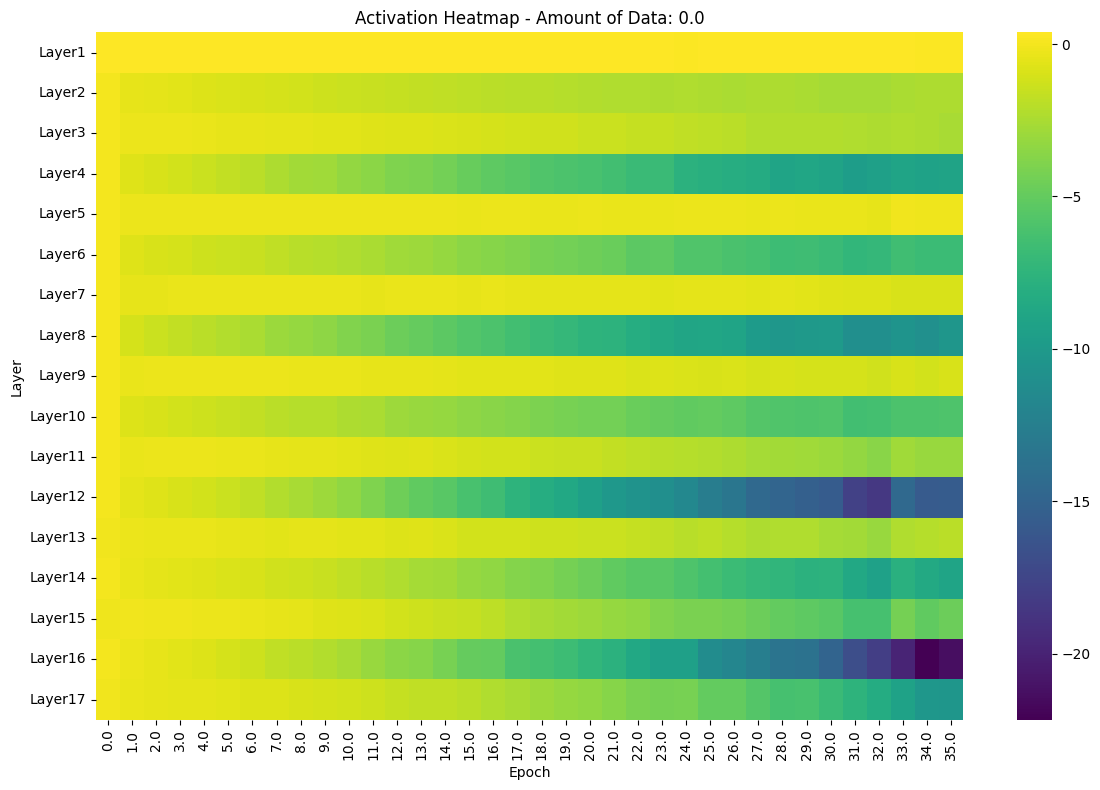

C:\Users\luord\AppData\Local\Temp\ipykernel_38852\457862474.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)


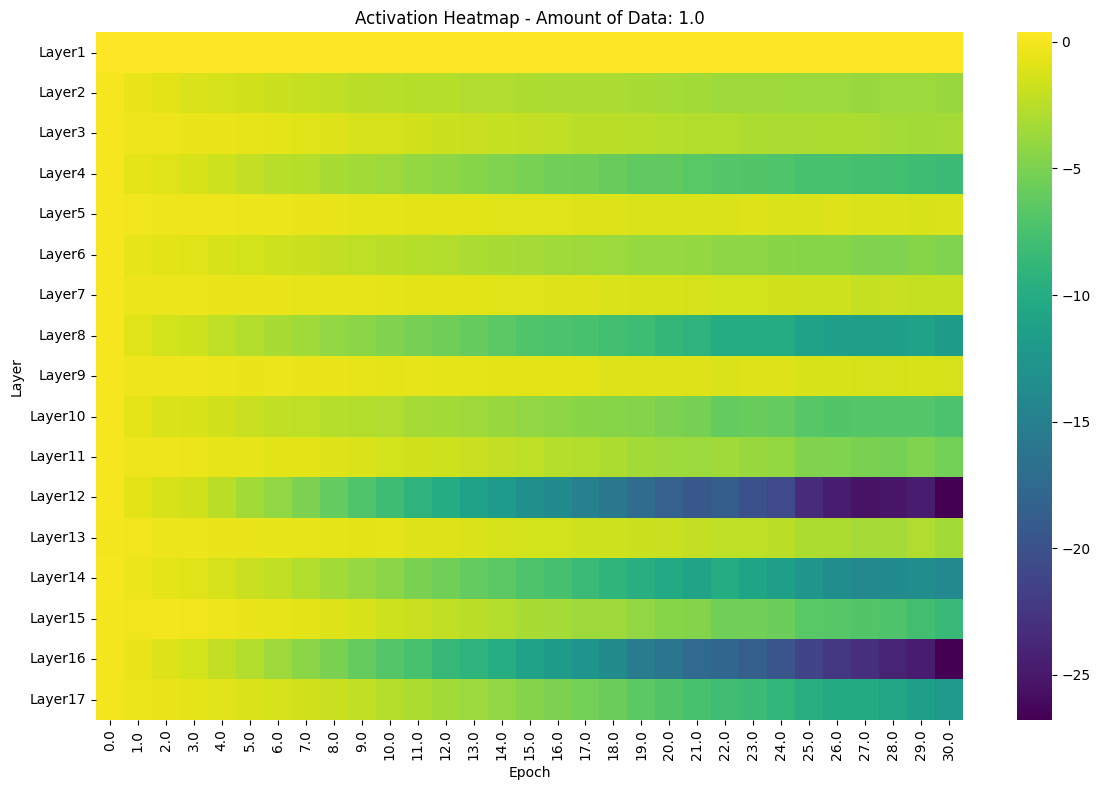

C:\Users\luord\AppData\Local\Temp\ipykernel_38852\457862474.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)


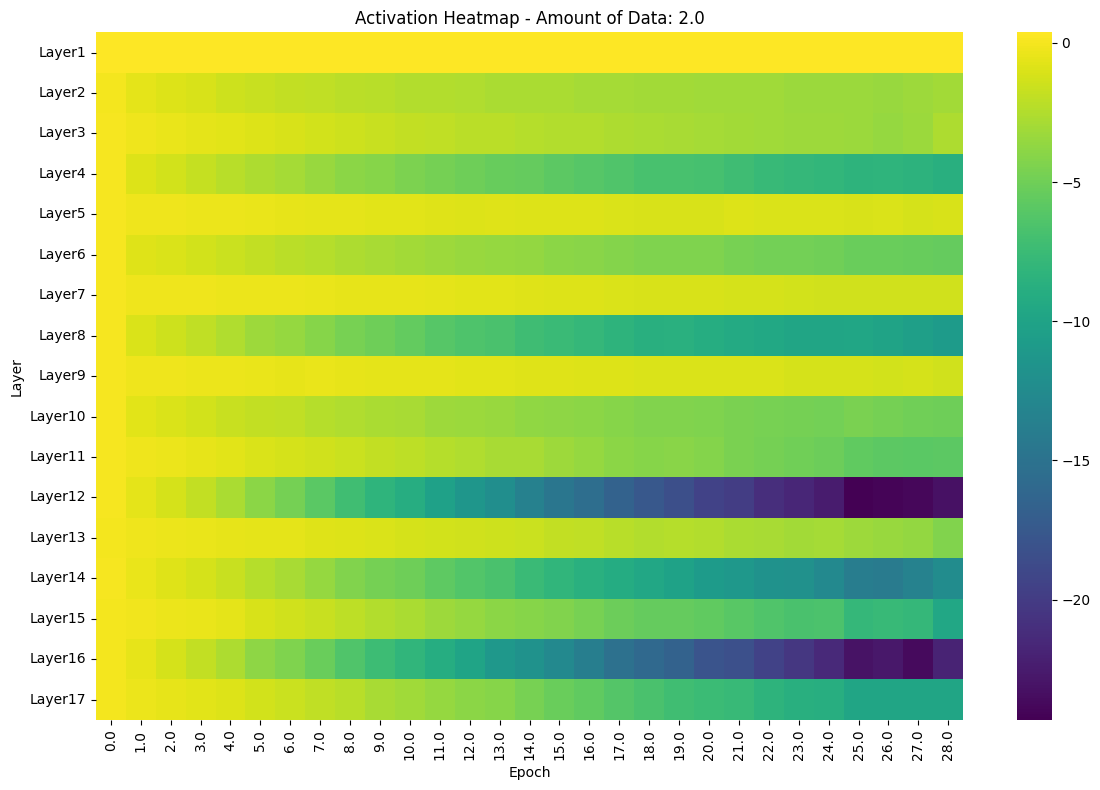

C:\Users\luord\AppData\Local\Temp\ipykernel_38852\457862474.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)


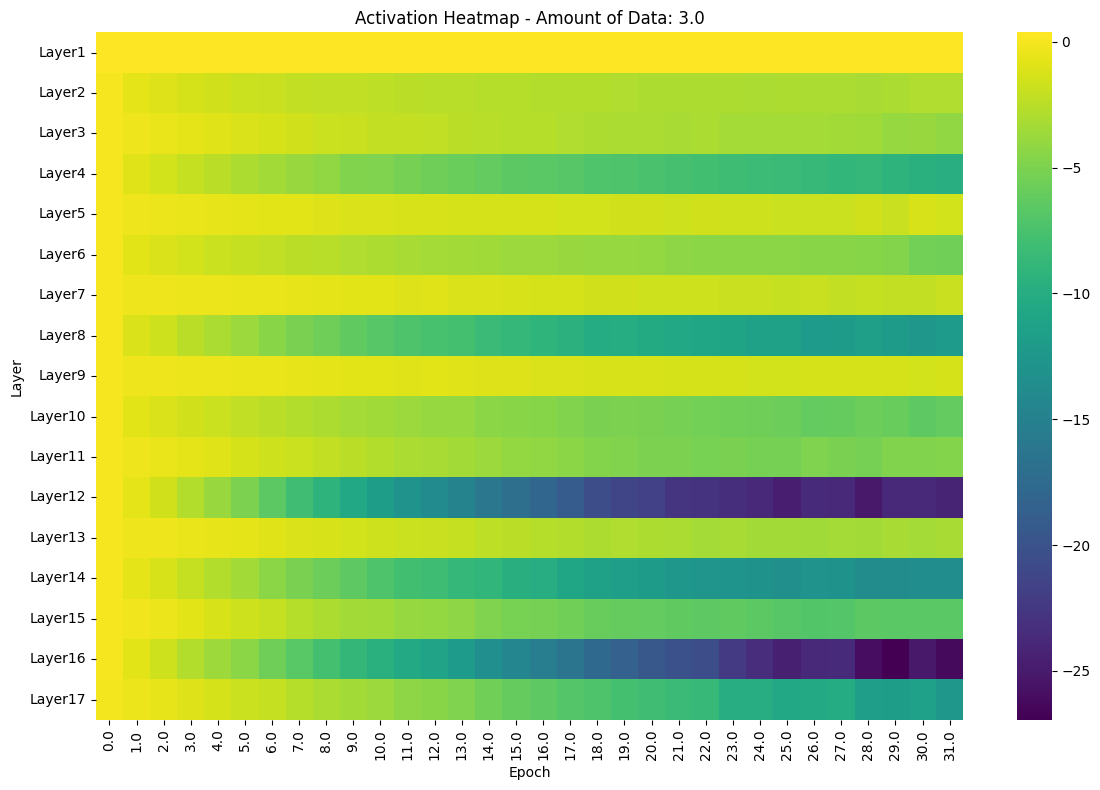

C:\Users\luord\AppData\Local\Temp\ipykernel_38852\457862474.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)


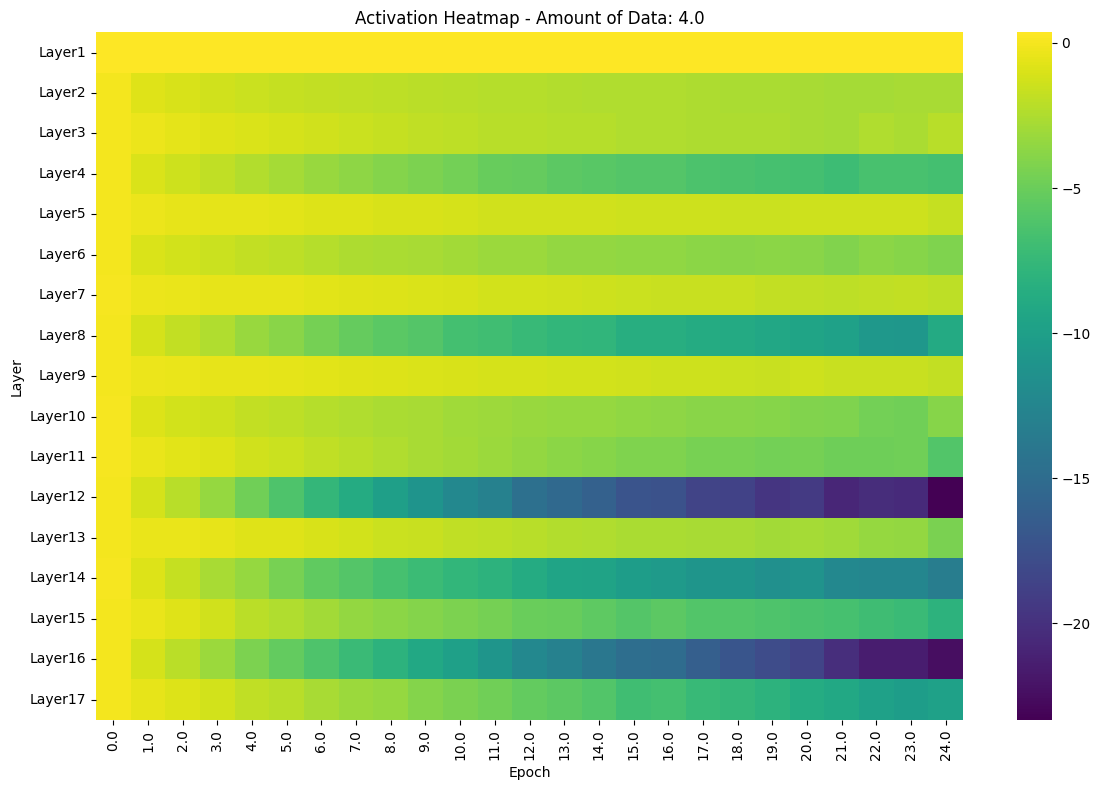

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('activations_per_layer.csv')

# Drop unused columns
columns_to_exclude = ['acc', 'avg_loss']
layer_columns = [col for col in df.columns if col.startswith('Layer')]
df_filtered = df.drop(columns=columns_to_exclude)

# Melt to long format
df_melted = df_filtered.melt(
	id_vars=['epoch', 'run', 'amount_of_data'], 
	value_vars=layer_columns, 
	var_name='layer', 
	value_name='activation'
)

unique_amounts = df_melted['amount_of_data'].unique()

for amount in unique_amounts:
	df_subset = df_melted[df_melted['amount_of_data'] == amount]

	# Extract numeric layer number for sorting
	df_subset['layer_num'] = df_subset['layer'].str.extract(r'(\d+)').astype(int)

	# Group, sort by numeric layer number
	df_grouped = (
		df_subset
		.groupby(['layer', 'layer_num', 'epoch'])['activation']
		.mean()
		.reset_index()
		.sort_values('layer_num')
	)

	# Set 'layer' as a categorical type to enforce layer order in the pivot
	df_grouped['layer'] = pd.Categorical(df_grouped['layer'], 
										categories=df_grouped.sort_values('layer_num')['layer'].unique(),
										ordered=True)
	
	# Pivot with properly sorted layers
	heatmap_data = df_grouped.pivot(index='layer', columns='epoch', values='activation')

	# Plot the heatmap
	plt.figure(figsize=(12, 8))
	sns.heatmap(heatmap_data, cmap='viridis', annot=False)
	plt.title(f'Activation Heatmap - Amount of Data: {amount}')
	plt.xlabel('Epoch')
	plt.ylabel('Layer')
	plt.tight_layout()
	plt.show()

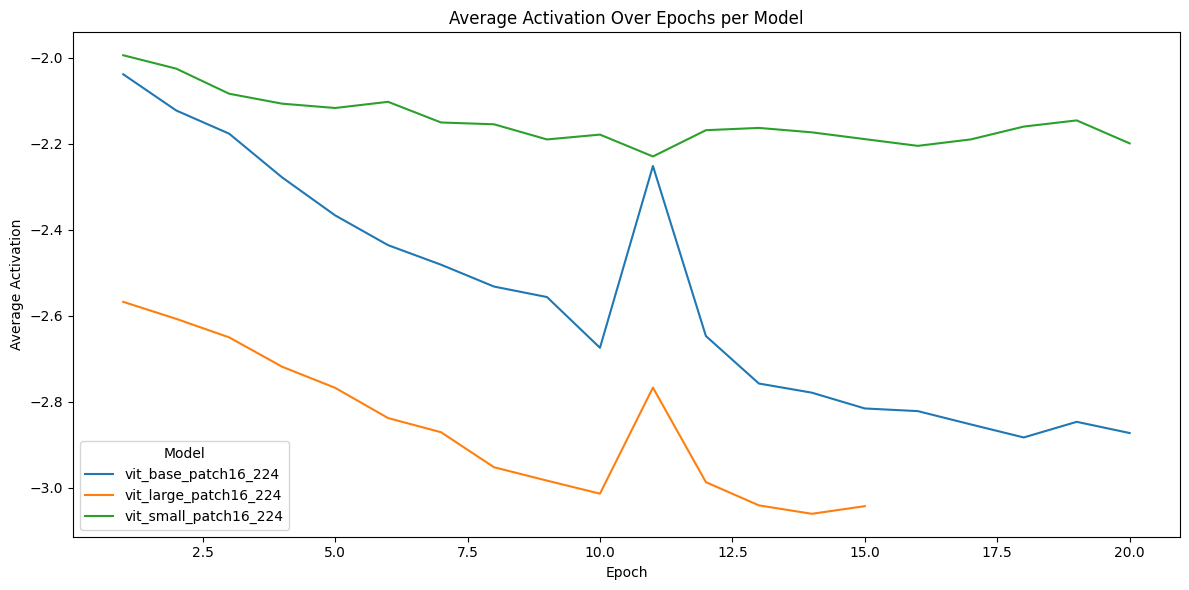

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('activations_csv/all_epochs.csv')


df_avg = df.groupby(['model', 'epoch'])['activation'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg, x='epoch', y='activation', hue='model')
plt.title('Average Activation Over Epochs per Model')
plt.xlabel('Epoch')
plt.ylabel('Average Activation')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

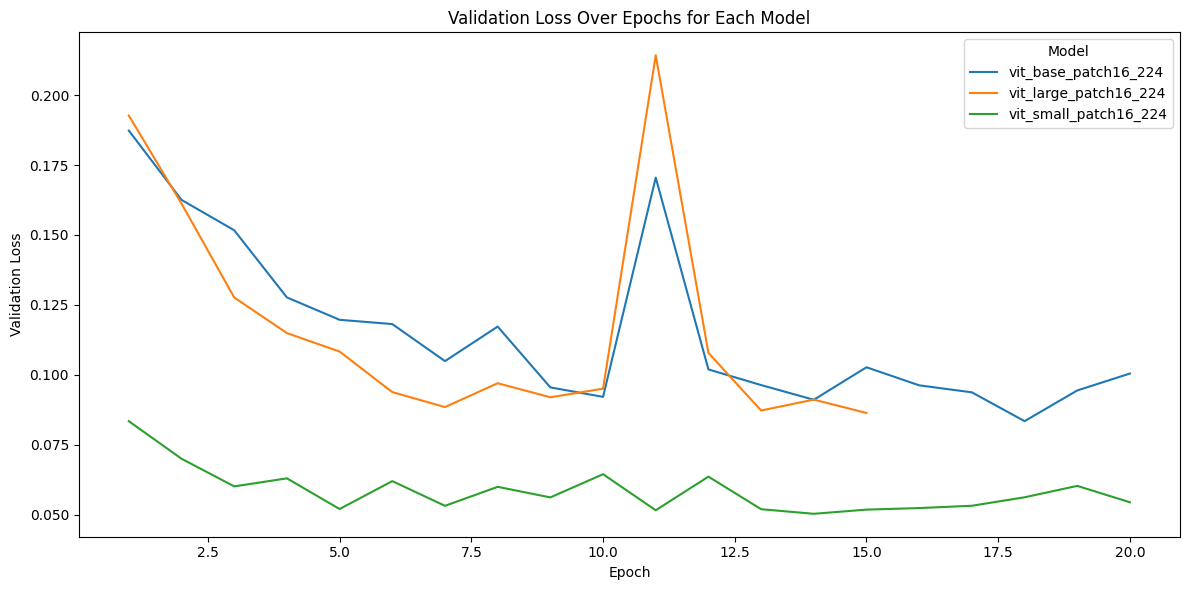

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_avg_loss = df.groupby(['model', 'epoch'])['val_loss'].mean().reset_index()


plt.figure(figsize=(12, 6))
sns.lineplot(data=df_avg_loss, x='epoch', y='val_loss', hue='model')
plt.title('Validation Loss Over Epochs for Each Model')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend(title='Model')
plt.tight_layout()
plt.show()

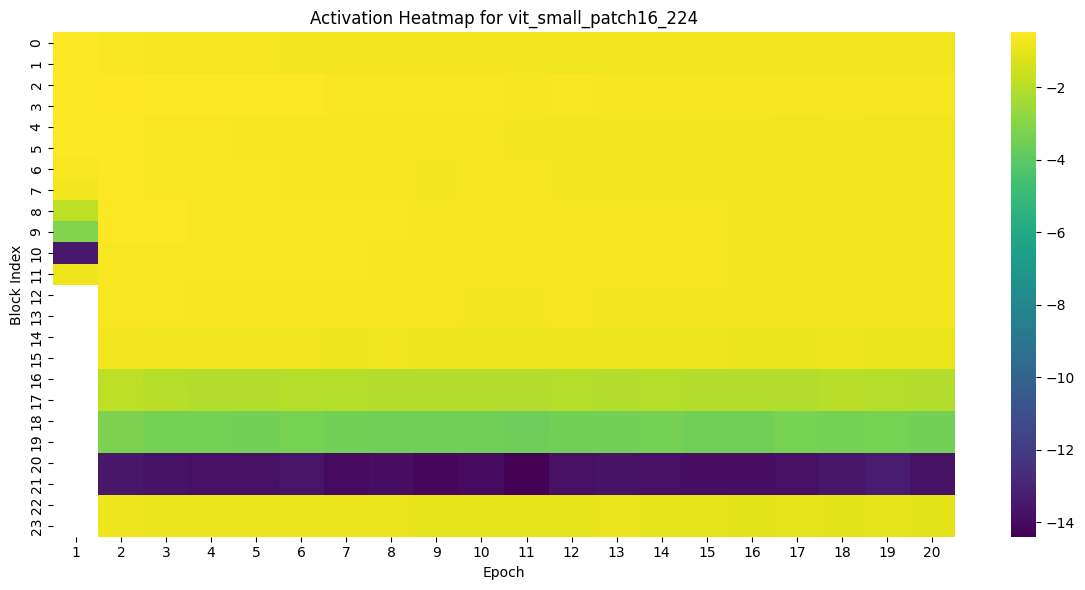

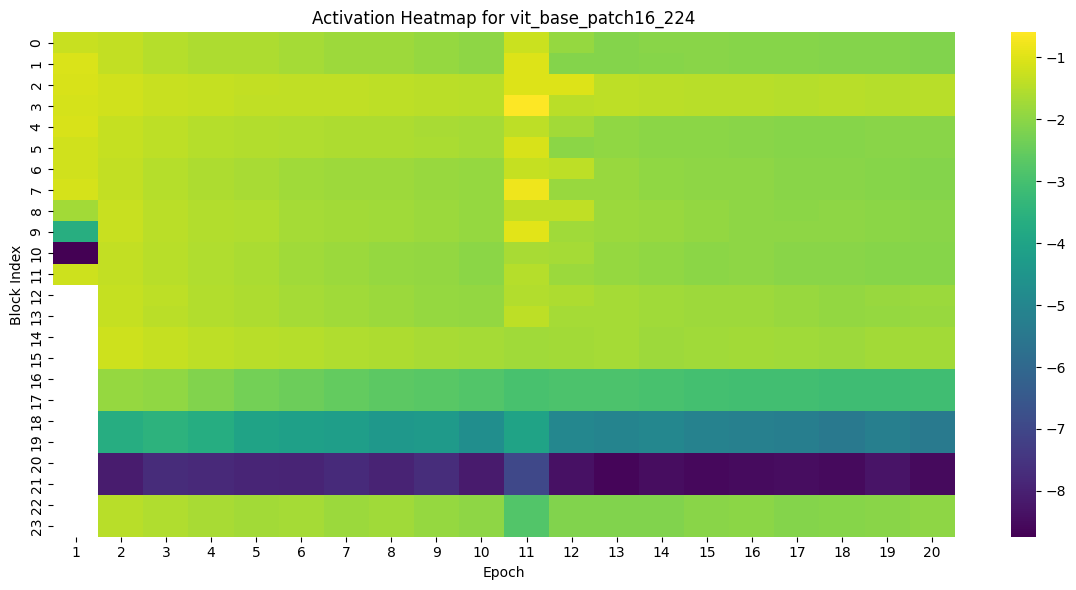

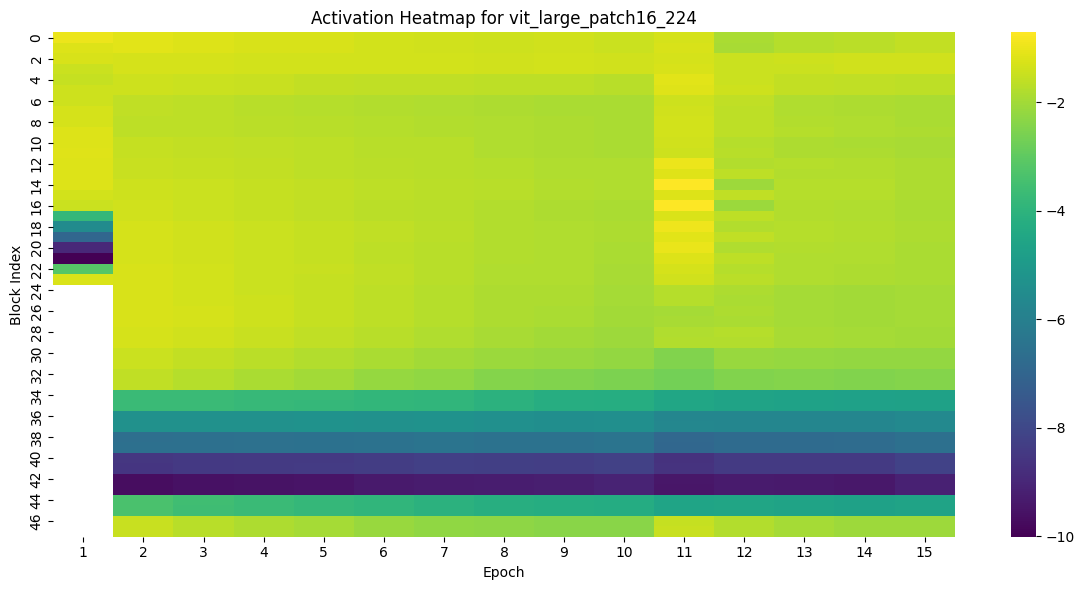

In [32]:
models = df['model'].unique()

for model_name in models:
    df_model = df[df['model'] == model_name]
    df_pivot = df_model.groupby(['block_idx', 'epoch'])['activation'].mean().reset_index()
    heatmap_data = df_pivot.pivot(index='block_idx', columns='epoch', values='activation')

    plt.figure(figsize=(12, 6))
    sns.heatmap(heatmap_data, cmap='viridis', annot=False)
    plt.title(f'Activation Heatmap for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Block Index')
    plt.tight_layout()
    plt.show()

Fitted scaling law: val_loss = 0.029 * model_size^0.260


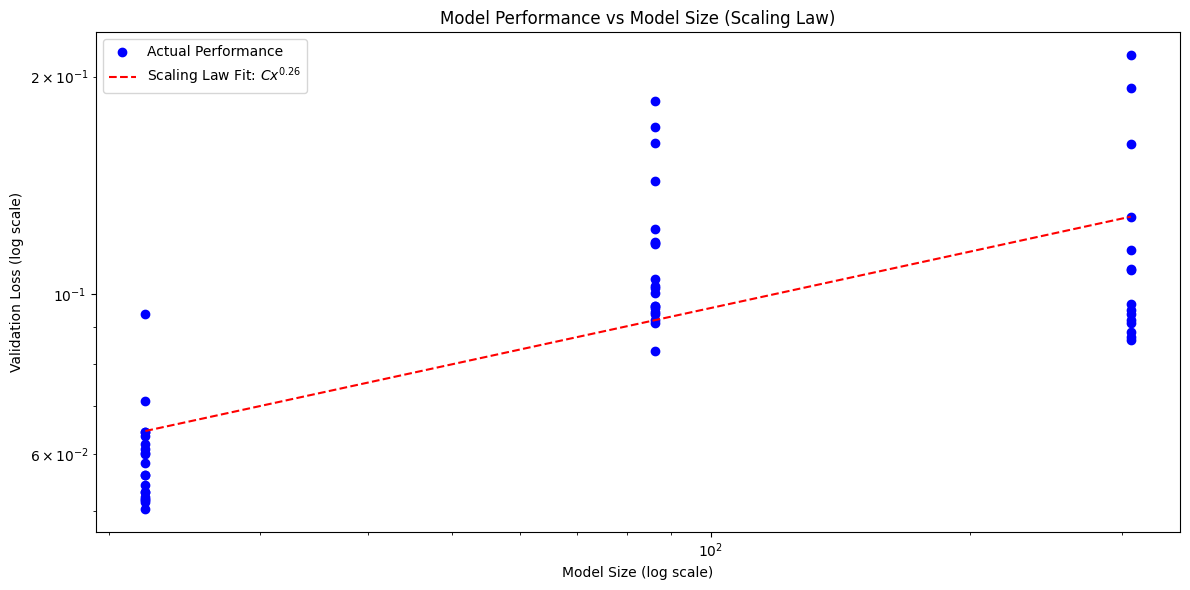

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


df_avg = df.groupby(['model', 'epoch'])['val_loss'].mean().reset_index()


model_size_dict = {
    'vit_small_patch16_224': 22.05, 
    'vit_base_patch16_224': 86.16,
    'vit_large_patch16_224': 307.48,
}

df_avg['model_size'] = df_avg['model'].map(model_size_dict)

df_avg = df_avg.dropna(subset=['model_size', 'val_loss'])


log_model_size = np.log(df_avg['model_size'])
log_val_loss = np.log(df_avg['val_loss'])

regressor = LinearRegression()
regressor.fit(log_model_size.values.reshape(-1, 1), log_val_loss)


log_C = regressor.intercept_
alpha = regressor.coef_[0]


C = np.exp(log_C)


print(f"Fitted scaling law: val_loss = {C:.3f} * model_size^{alpha:.3f}")


model_sizes_fit = np.linspace(min(df_avg['model_size']), max(df_avg['model_size']), 100)
val_loss_fit = C * model_sizes_fit ** alpha


plt.figure(figsize=(12, 6))
plt.scatter(df_avg['model_size'], df_avg['val_loss'], label='Actual Performance', color='blue')
plt.plot(model_sizes_fit, val_loss_fit, label=f'Scaling Law Fit: $C x^{{{alpha:.2f}}}$', color='red', linestyle='--')


plt.xscale('log')
plt.yscale('log')

plt.title('Model Performance vs Model Size (Scaling Law)')
plt.xlabel('Model Size (log scale)')
plt.ylabel('Validation Loss (log scale)')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 3) set up a hook to capture pre‑GELU activations
pre_acts = []  # will be a list of tensors, one per block

def grab_pre_activation(module, inp, outp):
	# inp[0] is the Tensor coming out of the linear layer, before GELU
	pre_acts.append(inp[0].detach())

# register hook on every MLP’s first Linear → GELU
for blk in model.blocks:
	# print(blk)
	blk.mlp.fc1.register_forward_hook(grab_pre_activation)

# 4) run one batch (or more)
with torch.no_grad():
	for images, _ in train_loader:
		_ = model(images)
		break
		
# 5) compute stats
for i, pa in enumerate(pre_acts):
	# pa shape: [batch, num_patches+1, embed_dim]
	mean = pa.mean().item()
	frac_pos = (pa > 0).float().mean().item()
	print(f"Block {i:2d}:  mean={mean:.4f},  frac(>0)={frac_pos:.3%}")

['vit_small_patch16_18x2_224', 'vit_small_patch16_36x1_224', 'vit_small_patch16_224', 'vit_small_patch16_384']
Block  0:  mean=-0.0035,  frac(>0)=49.492%
Block  1:  mean=-0.0087,  frac(>0)=49.654%
Block  2:  mean=-0.0042,  frac(>0)=49.478%
Block  3:  mean=-0.0065,  frac(>0)=49.649%
Block  4:  mean=-0.0081,  frac(>0)=49.927%
Block  5:  mean=-0.0056,  frac(>0)=49.859%
Block  6:  mean=-0.0086,  frac(>0)=49.664%
Block  7:  mean=-0.0190,  frac(>0)=49.548%
Block  8:  mean=-0.1109,  frac(>0)=48.202%
Block  9:  mean=-0.1235,  frac(>0)=48.781%
Block 10:  mean=-0.1462,  frac(>0)=49.305%
Block 11:  mean=-0.0239,  frac(>0)=48.949%


In [ ]:
import torch
import timm
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from collections import defaultdict
import gc

# Training loop
def train_model(model, train_loader, val_loader, epochs=10):
	
	# Loss & optimizer
	criterion = nn.CrossEntropyLoss()
	optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

	block_acts = defaultdict(dict)
	avg_acts = []  # Final average activations (fc1 + fc2) per block

	model_name = model.default_cfg['architecture']
	hooks = []

	def make_hook(block_idx, layer_name):
		def hook(module, inp, outp):
			if not module.training:
				act = outp.detach()[1:]  # Remove CLS token
				mean_val = act.mean().item()

				block_acts[block_idx][layer_name] = mean_val

				if 'fc1' in block_acts[block_idx] and 'fc2' in block_acts[block_idx]:
					avg_val = (block_acts[block_idx]['fc1'] + block_acts[block_idx]['fc2']) / 2
					avg_acts.append(avg_val)

		return hook

	for idx, blk in enumerate(model.blocks):
		hook_fc1 = blk.mlp.fc1.register_forward_hook(make_hook(idx, 'fc1'))
		hook_fc2 = blk.mlp.fc2.register_forward_hook(make_hook(idx, 'fc2'))
		hooks.append(hook_fc1)
		hooks.append(hook_fc2)
		
	for epoch in range(epochs):
		model.train()
		running_loss = 0.0
		correct = 0
		total = 0

		loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")

		for images, labels in train_loader:
			images, labels = images.to(device), labels.to(device)

			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			optimizer.zero_grad()

			running_loss += loss.item() * images.size(0)
			_, predicted = outputs.max(1)
			total += labels.size(0)
			correct += predicted.eq(labels).sum().item()

			loop.set_postfix(loss=loss.item(), acc=100. * correct / total)

		train_loss = running_loss / len(train_loader.dataset)
		train_acc = 100. * correct / total

		# Validation
		model.eval()
		val_loss = 0.0
		val_correct = 0
		val_total = 0
		avg_acts = []

		with torch.no_grad():
			for images, labels in val_loader:
				images, labels = images.to(device), labels.to(device)
				outputs = model(images)
				loss = criterion(outputs, labels)
				val_loss += loss.item() * images.size(0)
				_, predicted = outputs.max(1)
				val_total += labels.size(0)
				val_correct += predicted.eq(labels).sum().item()
				break # Only do one batch for validation to grab the preactivations

		val_loss /= len(val_loader.dataset)
		val_acc = 100. * val_correct / val_total

		print(f"\nEpoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

		# Build DataFrame
		rows = []
		for block_idx, avg_activation in enumerate(avg_acts):
			row = {
				"model": model_name,
				"epoch": epoch + 1,
				"block_idx": block_idx,
				"val_loss": val_loss,
				"val_acc": val_acc,
				"activation": avg_activation,
			}
			rows.append(row)

		df = pd.DataFrame(rows)

		# Save as CSV
		os.makedirs("activations_csv", exist_ok=True)
		csv_path = "activations_csv/all_epochs.csv"
		if not os.path.exists(csv_path):
			df.to_csv(csv_path, index=False)
		else:
			df.to_csv(csv_path, mode='a', header=False, index=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = [timm.create_model('vit_small_patch16_224', pretrained=True), timm.create_model('vit_small_patch16_224', pretrained=True), timm.create_model('vit_small_patch16_224', pretrained=True)]

transform = transforms.Compose([
	transforms.Resize((224, 224)), 
	transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
	transforms.ToTensor(),
	transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=500, shuffle=True, num_workers=1) 

# 1) load a pretrained ViT
for model in models:
	model.to(device)

	train_model(model, train_loader, test_loader, epochs=5)
	
	# Clean up
	model.to('cpu')
	del model
	torch.cuda.empty_cache()
	gc.collect()

Epoch [1/2]:   0%|          | 0/313 [00:29<?, ?it/s, acc=6.08, loss=3.42] 

In [ ]:
import torch
import timm
import pytorch_lightning as pl
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torchmetrics
from pytorch_lightning import Trainer

# LightningModule wrapper
class ViTLightningModel(pl.LightningModule):
	def __init__(self, model_name='vit_small_patch16_224', num_classes=100):
		super().__init__()
		self.model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
		self.criterion = nn.CrossEntropyLoss()
		self.accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

	def forward(self, x):
		return self.model(x)

	def training_step(self, batch, batch_idx):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)
		acc = self.accuracy(logits, y)
		self.log("train_loss", loss, prog_bar=True)
		self.log("train_acc", acc, prog_bar=True)
		return loss

	def validation_step(self, batch, batch_idx):
		x, y = batch
		logits = self(x)
		loss = self.criterion(logits, y)
		acc = self.accuracy(logits, y)
		self.log("val_loss", loss, prog_bar=True)
		self.log("val_acc", acc, prog_bar=True)

	def configure_optimizers(self):
		return torch.optim.AdamW(self.parameters(), lr=3e-4)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model and Trainer
model = ViTLightningModel(model_name='vit_small_patch16_224')

models = [ViTLightningModel(model_name='vit_small_patch16_224'), ViTLightningModel(model_name='vit_small_patch16_224'), ViTLightningModel(model_name='vit_small_patch16_224')]

transform = transforms.Compose([
	transforms.Resize((224, 224)), 
	transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
	transforms.ToTensor(),
	transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=1)
test_loader = DataLoader(testset, batch_size=32, shuffle=True, num_workers=1) 

# 1) load a pretrained ViT
for model in models:
	trainer = Trainer(
		max_epochs=5,
		accelerator="gpu",
		devices=2,         # Or use `devices=-1` to use all GPUs
		strategy="ddp",    # DistributedDataParallel
		precision=16,      # Mixed precision (optional but helps with memory)
	)

	trainer.fit(model, train_loader, test_loader)

c:\Users\luord\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning_fabric\connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!


MisconfigurationException: You requested gpu: [0, 1]
 But your machine only has: [0]

In [ ]:
import torch
import timm
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch import nn, optim
from pytorch_lightning import Trainer

import pytorch_lightning as pl
import torch
import timm
from torch import nn

class ViTLightningWithHooks(pl.LightningModule):
	def __init__(self, model_name):
		super(ViTLightningWithHooks, self).__init__()
		self.model = timm.create_model(model_name, pretrained=True)
		self.block_acts = {}
		self.avg_acts = []

		# Register hooks for layers
		self._register_hooks()

	def forward(self, x):
		return self.model(x)

	def _register_hooks(self):
		"""
		Registers forward hooks for all the layers that we want to track
		"""
		def make_hook(block_idx, layer_name):
			def hook(module, inp, outp):
				if not module.training:
					act = outp.detach()[1:]  # Remove CLS token
					mean_val = act.mean().item()

					if block_idx not in self.block_acts:
						self.block_acts[block_idx] = {}
					self.block_acts[block_idx][layer_name] = mean_val

					if 'fc1' in self.block_acts[block_idx] and 'fc2' in self.block_acts[block_idx]:
						avg_val = (self.block_acts[block_idx]['fc1'] + self.block_acts[block_idx]['fc2']) / 2
						self.avg_acts.append(avg_val)

			return hook

		# Register hooks for all blocks and layers (assuming you have ViT model structure with 'blocks')
		for idx, blk in enumerate(self.model.blocks):
			blk.mlp.fc1.register_forward_hook(make_hook(idx, 'fc1'))
			blk.mlp.fc2.register_forward_hook(make_hook(idx, 'fc2'))

	def training_step(self, batch, batch_idx):
		images, labels = batch
		outputs = self(images)
		loss = nn.CrossEntropyLoss()(outputs, labels)
		return loss

	def validation_step(self, batch, batch_idx):
		images, labels = batch
		outputs = self(images)
		loss = nn.CrossEntropyLoss()(outputs, labels)
		_, predicted = torch.max(outputs, 1)
		acc = (predicted == labels).sum().item() / len(labels)
		return {"val_loss": loss, "val_acc": acc}

	def validation_epoch_end(self, outputs):
		avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
		avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()
		return {"val_loss": avg_loss, "val_acc": avg_acc, "actvs": self.avg_acts}

	def configure_optimizers(self):
		optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4)
		return optimizer

transform = transforms.Compose([
	transforms.Resize((224, 224)), 
	transforms.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
	transforms.ToTensor(),
	transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=4)

# Initialize models
model_names = ['vit_small_patch16_224', 'vit_base_patch16_224', 'vit_large_patch16_224']
models = [ViTLightningWithHooks(model_name) for model_name in model_names]

# Setup Trainer for multi-GPU (DataParallel or DDP)
trainer = Trainer(
	accelerator="gpu",  # For multi-GPU training
	strategy="ddp_notebook",     # Distributed Data Parallel strategy (for multiple GPUs)
	max_epochs=1,       # Set your desired number of epochs
)

# Train all models
for model in models:
	trainer.fit(model, train_loader, val_loader)

ValueError: You selected `Trainer(strategy='ddp_notebook')` but process forking is not supported on this platform. We recommed `Trainer(strategy='ddp_spawn')` instead.

In [ ]:
# Create a 'time' column based on the order (index) of the rows
df['time'] = df.index // 2  # Assuming 3 runs per time point

# Calculate the mean and standard deviation for each time point
time_means = df.groupby('time')['average'].mean()
time_stds = df.groupby('time')['average'].std()

# Convert the mean and std into DataFrame for plotting
time_means_df = pd.DataFrame({'time': time_means.index, 'mean': time_means.values})
time_stds_df = pd.DataFrame({'time': time_stds.index, 'std': time_stds.values})

print(time_means_df)
print(time_stds_df)

# print(time_means_df.iloc[155:165])

# Plot the time series with error bands
plt.figure(figsize=(10, 6))

# Plot the mean values
sns.lineplot(x='time', y='mean', data=time_means_df, label='Mean', color='b')

# Add error bands
plt.fill_between(time_stds_df['time'], 
				 time_means_df['mean'] - time_stds_df['std'], 
				 time_means_df['mean'] + time_stds_df['std'], 
				 color='blue', alpha=0.3)

plt.title("Time Series with Error Bands (Standard Deviation)")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()